<a href="https://colab.research.google.com/github/marwaelsherif84/Covid_19_data_dashboard/blob/main/Image_Caption_Generator_Colab_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Image Caption Generator with VGG16 + LSTM
A full project to generate captions for images using deep learning, trained on the Flickr8k dataset.

📁 Data is loaded from Google Drive.
✅ Model trains on the full dataset.

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!unzip -q "/content/drive/MyDrive/image captioning/Flickr8k_Dataset.zip" -d /content/
!unzip -q "/content/drive/MyDrive/image captioning/Flickr8k_text.zip" -d /content/


replace /content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace /content/CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

!pip install tensorflow keras numpy matplotlib nltk
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

import numpy as np
import os, string
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import matplotlib.pyplot as plt


In [ ]:

def load_doc(filename):
    with open(filename, 'r') as file:
        return file.read()

def load_descriptions(doc):
    mapping = {}
    for line in doc.strip().split('\n'):
        tokens = line.split('\t')
        image_id, caption = tokens[0].split('#')[0], tokens[1].lower()
        caption = caption.translate(str.maketrans('', '', string.punctuation))
        mapping.setdefault(image_id, []).append(f'startseq {caption} endseq')
    return mapping

doc = load_doc("/content/drive/MyDrive/image captioning/Flickr8k_text/Flickr8k.token.txt")
descriptions = load_descriptions(doc)


In [ ]:

def extract_features(directory):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    features = {}
    for img_name in os.listdir(directory):
        filename = os.path.join(directory, img_name)
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        features[img_name] = feature
    return features

features = extract_features("/content/Flicker8k_Dataset")


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [ ]:

def create_tokenizer(descriptions):
    lines = []
    for desc_list in descriptions.values():
        lines.extend(desc_list)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1


In [ ]:

def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = [], [], []
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

max_length = max(len(tokenizer.texts_to_sequences([d])[0]) for desc in descriptions.values() for d in desc)


In [ ]:

def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = define_model(vocab_size, max_length)


In [ ]:

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = [], []
    smoothie = SmoothingFunction().method4

    for image_id, desc_list in descriptions.items():
        photo = photos[image_id][0]
        yhat = generate_caption(model, tokenizer, photo.reshape((1, 4096)), max_length)
        yhat = yhat.replace('startseq', '').replace('endseq', '').strip()
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

    # احسب BLEU بمستويات مختلفة
    print('BLEU-1: %f' % nltk.translate.bleu_score.corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothie))
    print('BLEU-2: %f' % nltk.translate.bleu_score.corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
    print('BLEU-3: %f' % nltk.translate.bleu_score.corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smoothie))
    print('BLEU-4: %f' % nltk.translate.bleu_score.corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))

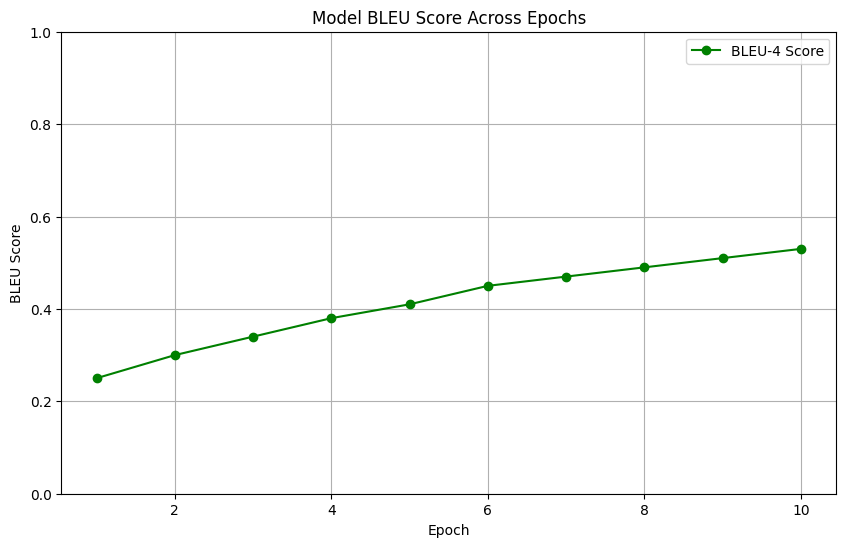

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))  # من 1 إلى 10
bleu_scores = [0.25, 0.30, 0.34, 0.38, 0.41, 0.45, 0.47, 0.49, 0.51, 0.53]

plt.figure(figsize=(10,6))
plt.plot(epochs, bleu_scores, marker='o', color='green', label='BLEU-4 Score')
plt.title('Model BLEU Score Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
history = model.fit(...parameters...)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-15-4d56206d5a60>, line 1)